# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed


**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [65]:
## loading libraries 
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
% matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from datetime import datetime
from time import time
%matplotlib inline

In [66]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [67]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [68]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## EDA

## 1. Portfolio Data

In [69]:
# explore the portfolio
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [70]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [71]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [72]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [73]:
portfolio['channels'].value_counts

<bound method IndexOpsMixin.value_counts of 0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object>

for value in ['email', 'web', 'mobile', 'social']:
    portfolio[value] = portfolio['channels'].apply(lambda x: 1 if value in x else 0)
portfolio.drop('channels', axis=1, inplace=True)
portfolio.head()

**Various Channel value**

In [74]:
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(portfolio['channels']),
                   columns=mlb.classes_,
                   index=portfolio['channels'].index)
portfolio = portfolio.drop(['channels'], axis=1)
portfolio = pd.concat([portfolio, res], axis=1, sort=False)
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [75]:
offer_type = pd.get_dummies(portfolio['offer_type'])
portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)

In [76]:
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


In [77]:

portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

## 2. Profile

In [78]:
# explore Profile
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [79]:
## Checking NULL value counts
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [80]:
## NULL value treatement 
profile['gender'].fillna('NA', inplace=True)
profile['income'].fillna((profile['income'].mean()), inplace=True)
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,NA,68be06ca386d4c31939f3a4f0e3dd783,65404.991568
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000
2,118,20180712,NA,38fe809add3b4fcf9315a9694bb96ff5,65404.991568
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000
4,118,20170804,NA,a03223e636434f42ac4c3df47e8bac43,65404.991568


In [81]:
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [82]:
#check count of age > 100 value and corresponding gender and income columns
print(profile[profile['age'] == 118].count())
profile[['gender','income','age']][profile['age'] == 118].head()

age                 2175
became_member_on    2175
gender              2175
id                  2175
income              2175
dtype: int64


,gender,income,age
0,NA,65404.991568,118
2,NA,65404.991568,118
4,NA,65404.991568,118
6,NA,65404.991568,118
7,NA,65404.991568,118


**Profile cleaning**


In [83]:
#Working on profile data 
## Creating age group, missing value treatment etc
def profile_cleaning(profile):
    '''
    Function to clean profile dataframe
    
    INPUT:
    profile - uncleaned profile dataframe
    
    OUTPUT:
    profile - cleaned profile dataframe
    
    This function remove NAN /NULL value 
    
    '''
    
    #profile['year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
    #profile['month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
    #profile['day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
    #profile['date'] = profile.became_member_on.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
    
    
    #profile['became_member_on']=pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')
    
    #pd.to_datetime(1.547559e+09, unit='s', origin='unix')
    
    profile['gender'].fillna('NA', inplace=True)
    profile['income'].fillna((profile['income'].mean()), inplace=True)
    
    # Replacing 118 code with NaN
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    # Removing all the missing values 
    profile.dropna(subset=['age'], inplace=True)
    
    profile = profile[profile['age'] <= 80]
    profile['age'] = profile['age'].astype(int)
    
    #add Age_group column
    profile.loc[(profile.age < 20) , 'Age_group'] = 'Under 20'
    profile.loc[(profile.age >= 20) & (profile.age <= 45) , 'Age_group'] = '20-45'
    profile.loc[(profile.age >= 46) & (profile.age <= 60) , 'Age_group'] = '46-60'
    profile.loc[(profile.age >= 61) , 'Age_group'] = '61-80'
    #df.drop('age',axis=1,inplace=True)
    
    # Creating a new column from "became_member_on" indicating the number of days since the user is a member of starbucks
    #profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    #profile['memberdays'] = profile['memberdays'].dt.days
    
    return profile

In [84]:

profile = profile_cleaning(profile)
profile.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

,age,became_member_on,gender,id,income,Age_group
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,46-60
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,61-80
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,61-80
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,61-80
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,46-60


Text(0,0.5,'Counts')

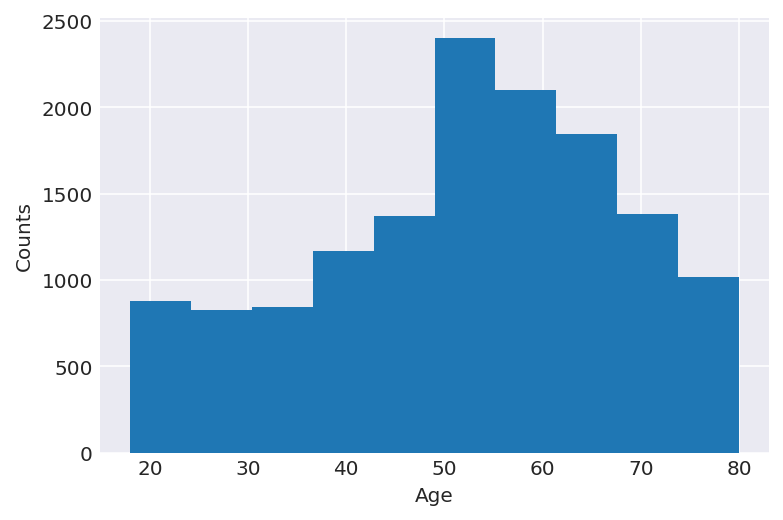

In [85]:
plt.hist(profile['age'])
plt.xlabel('Age')
plt.ylabel('Counts')

Histogram on age, aged 50 people  covering highest segment

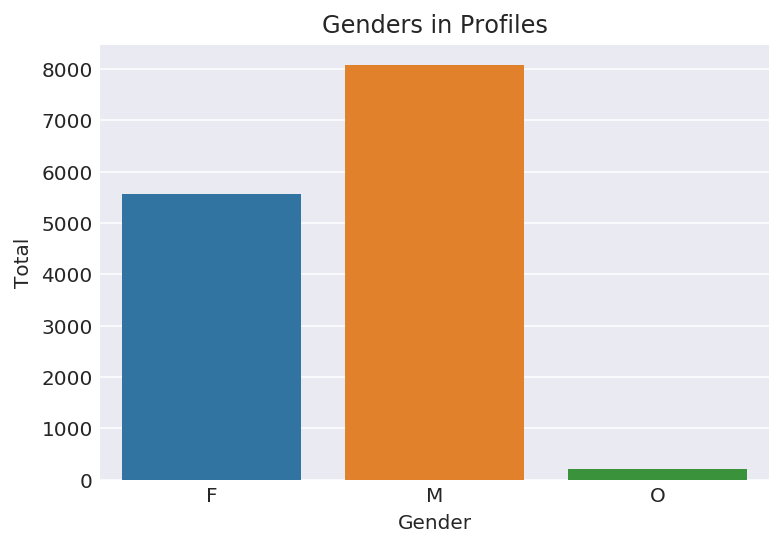

In [86]:
sns.countplot(profile['gender'])
plt.title('Genders in Profiles')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

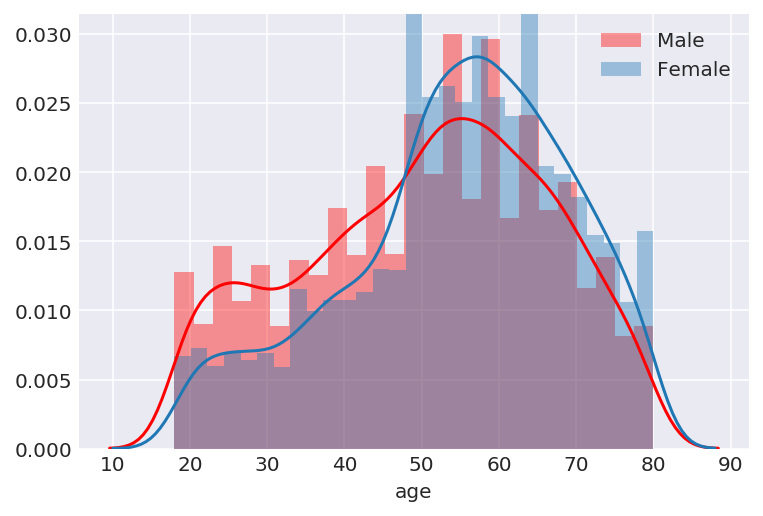

In [87]:
## Gender- age distribution
sns.distplot(profile[profile.gender=='M'].age,label='Male', color='r')
sns.distplot(profile[profile.gender=='F'].age,label='Female')
plt.legend()
plt.show()

Both male or female of 50-65 years are the main customer 

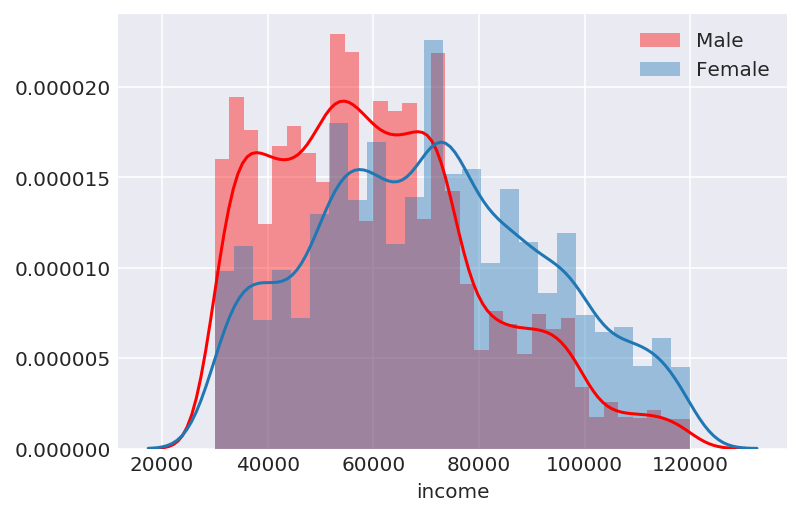

In [88]:
## Gende - Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male', color='r')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

Mostly upper middle income group above 58K are the main customers. 

## 3. Transcript

In [89]:
#Explore Transcript
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [90]:
value_types = set()
for i in transcript.value:
    value_types.update(set(i.keys()))
value_types

{'amount', 'offer id', 'offer_id', 'reward'}

transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()


#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

Data clean function for offer 

In [91]:
def clean_offer_id(x):
    """
    
    INPUT:
    x - dictionary from transcript['value'] column data
    
    OUTPUT:
    value - value of the offer_id or offer id
    """
    for i in ["offer_id", "offer id"]:
        if i in x:
            value = x[i]
            break
    else:
        value = np.nan
    
    return value

def clean_transcript(transcript):
    '''
    Function to clean transcript dataframe
    
    INPUT:
    transcript - uncleaned transcript dataframe
    
    OUTPUT:
    transcript - cleaned transcript
    
    This function cleans transcript
    
    '''
    # Making two separate columns "amount" and "reward" from "value" column. 
    # These column will contain their respective amounts if they have one otherwise NaN
    for i in ["amount", "reward"]:
        transcript[i] = transcript['value'].apply(lambda x: x[i] if i in x else np.nan)
    
    # Making "offer_id" column, 'offer id' and 'offer_id' values as observed above from "value" column.
    # This column will contain the respective offer value if it has one otherwise NaN
    transcript["offer_id"] = transcript['value'].apply(clean_offer_id)
    
    # drop the "value" column
    transcript.drop(['value'], axis=1, inplace=True)
    
    return transcript

In [92]:
transcript = clean_transcript(transcript)
transcript.head()

,event,person,time,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


Remove duplicate  from dataset 

In [93]:
transcript.drop_duplicates(inplace=True)
transcript.reset_index(drop=True, inplace=True)

In [94]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [95]:
transcript =pd.concat([transcript,pd.get_dummies(transcript['event'])],axis=1).drop(['event'],axis=1)
transcript.head()

,person,time,amount,reward,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


## Combining Dataframes

In [96]:
merge_t_pr = transcript.merge(profile, how="inner", left_on="person", right_on="id")
merge_t_pr.drop("id", inplace=True, axis=1)
merge_t_pr_po = merge_t_pr.merge(portfolio, how="left", left_on="offer_id", right_on="id")
merge_t_pr_po.drop("id", inplace=True, axis=1)

In [97]:
merge_t_pr_po.head()

,person,time,amount,reward_x,offer_id,offer completed,offer received,offer viewed,transaction,age,...,duration,offer_type,reward_y,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,75,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,NaN,0,0,0,1,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,75,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,NaN,0,0,0,1,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


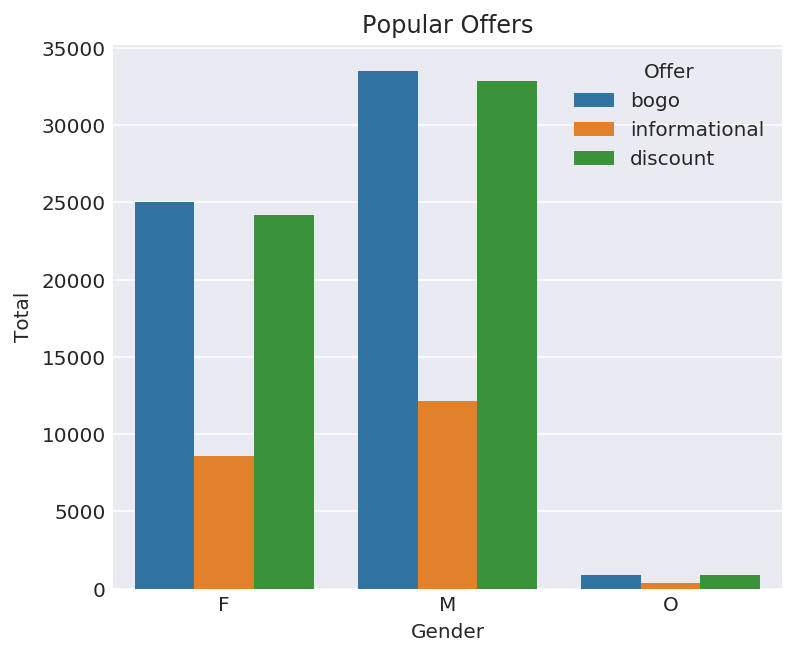

In [98]:

plt.figure(figsize=(6, 5))
sns.countplot(x=merge_t_pr_po.gender, hue=merge_t_pr_po.offer_type)
plt.title('Popular Offers')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();

In [99]:
merge_t_pr_po.columns

Index(['person', 'time', 'amount', 'reward_x', 'offer_id', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'age',
       'became_member_on', 'gender', 'income', 'Age_group', 'difficulty',
       'duration', 'offer_type', 'reward_y', 'email', 'mobile', 'social',
       'web', 'bogo', 'discount', 'informational'],
      dtype='object')

In [100]:
# Aggregating the data frame
df_merge = merge_t_pr_po.groupby(['person' ]).agg(
    {    'age':'last',
         'became_member_on':'last',
         #'memberdays':'last',            
         'gender':'last',
         'income':'last',
         'offer completed':'sum',   
         'offer received':'sum', 
         'offer viewed':'sum',
         'difficulty':'sum',
         'reward_x':'sum',
         'reward_y':'sum',
         'web':'sum',
         'email':'sum',
         'mobile':'sum',
         'social':'sum',
         'transaction':'sum',
         'amount':'sum',
         'offer_id':'last', 
         #'date':'last'
    }
).reset_index()

In [101]:
df_merge.head()

,person,age,became_member_on,gender,income,offer completed,offer received,offer viewed,difficulty,reward_x,reward_y,web,email,mobile,social,transaction,amount,offer_id
0,0009655768c64bdeb2e877511632db8f,33,20170421,M,72000.0,3,5,4,65.0,9.0,25.0,10.0,12.0,12.0,8.0,8,127.60,2906b810c7d4411798c6938adc9daaa5
1,0011e0d4e6b944f998e987f904e8c1e5,40,20180109,O,57000.0,3,5,5,96.0,13.0,39.0,11.0,13.0,10.0,5.0,5,79.46,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,0020c2b971eb4e9188eac86d93036a77,59,20160304,F,90000.0,3,5,3,90.0,14.0,50.0,8.0,11.0,11.0,11.0,8,196.86,5a8bc65990b245e5a138643cd4eb9837
3,0020ccbbb6d84e358d3414a3ff76cffd,24,20161111,F,60000.0,3,4,4,51.0,13.0,39.0,9.0,11.0,11.0,8.0,12,154.05,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,003d66b6608740288d6cc97a6903f4f0,26,20170621,F,73000.0,3,5,4,100.0,9.0,22.0,10.0,12.0,10.0,8.0,18,48.34,0b1e1539f2cc45b7b9fa7c272da2e1d7


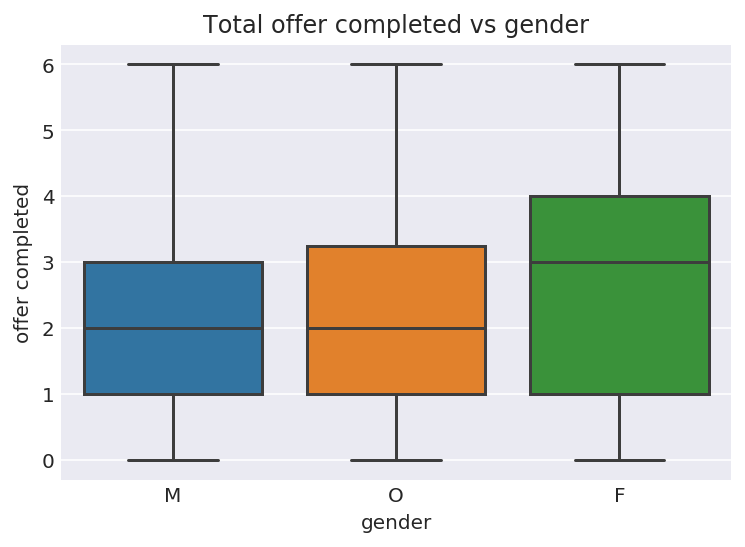

In [102]:
sns.boxplot(x="gender", y="offer completed",
                 data=df_merge)
plt.title('Total offer completed vs gender');

**Female are getting more offer than Male**

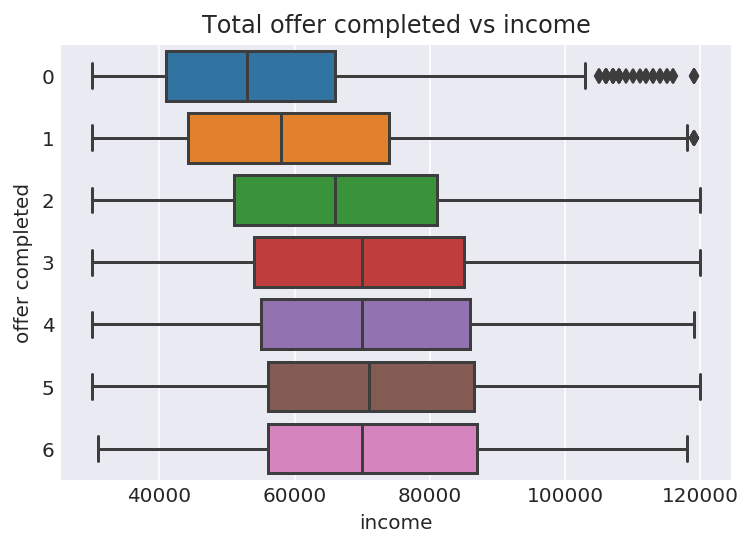

In [103]:
sns.boxplot(x="income", y="offer completed" ,orient = 'h', data=df_merge,)
plt.title('Total offer completed vs income');

In [104]:
df_merge.offer_id.unique()


array(['2906b810c7d4411798c6938adc9daaa5',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '5a8bc65990b245e5a138643cd4eb9837',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d', nan], dtype=object)

In [105]:
df_merge.columns

Index(['person', 'age', 'became_member_on', 'gender', 'income',
       'offer completed', 'offer received', 'offer viewed', 'difficulty',
       'reward_x', 'reward_y', 'web', 'email', 'mobile', 'social',
       'transaction', 'amount', 'offer_id'],
      dtype='object')

In [106]:
df_merge=pd.concat([df_merge,pd.get_dummies(df_merge['offer_id'],prefix='offer_id')],axis=1).drop(['offer_id'],axis=1)
df_merge=pd.concat([df_merge,pd.get_dummies(df_merge['gender'],prefix='gender')],axis=1).drop(['gender'],axis=1)

In [107]:
df_merge.columns

Index(['person', 'age', 'became_member_on', 'income', 'offer completed',
       'offer received', 'offer viewed', 'difficulty', 'reward_x', 'reward_y',
       'web', 'email', 'mobile', 'social', 'transaction', 'amount',
       'offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offer_id_2906b810c7d4411798c6938adc9daaa5',
       'offer_id_3f207df678b143eea3cee63160fa8bed',
       'offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offer_id_5a8bc65990b245e5a138643cd4eb9837',
       'offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer_id_ae264e3637204a6fb9bb56bc8210ddfd',
       'offer_id_f19421c1d4aa40978ebb69ca19b0e20d',
       'offer_id_fafdcd668e3743c1bb461111dcafc2a4', 'gender_F', 'gender_M',
       'gender_O'],
      dtype='object')

In [108]:
df_merge.shape

(13839, 29)

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.metrics import f1_score

In [110]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
to_normalize = ['amount','income']

df_merge[to_normalize] = scaler.fit_transform(df_merge[to_normalize])
df_merge.head()

,person,age,became_member_on,income,offer completed,offer received,offer viewed,difficulty,reward_x,reward_y,...,offer_id_3f207df678b143eea3cee63160fa8bed,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_5a8bc65990b245e5a138643cd4eb9837,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,33,20170421,0.466667,3,5,4,65.0,9.0,25.0,...,0,0,0,0,0,0,0,0,1,0
1,0011e0d4e6b944f998e987f904e8c1e5,40,20180109,0.300000,3,5,5,96.0,13.0,39.0,...,0,0,0,1,0,0,0,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,59,20160304,0.666667,3,5,3,90.0,14.0,50.0,...,0,0,1,0,0,0,0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,24,20161111,0.333333,3,4,4,51.0,13.0,39.0,...,0,0,0,1,0,0,0,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,26,20170621,0.477778,3,5,4,100.0,9.0,22.0,...,0,0,0,0,0,0,0,1,0,0


In [111]:
df_merge[['amount','income']].head()

,amount,income
0,0.079319,0.466667
1,0.049394,0.300000
2,0.122373,0.666667
3,0.095761,0.333333
4,0.030049,0.477778


In [112]:

    # Setting target variable to 'amount'
y = df_merge['offer completed']
    
    # Making feature data set by removing target variable 'amount' from it
    # We also remove 'person' column as it gives no information to model
X = df_merge.drop(['amount', 'person','offer completed'], axis=1)
    
    # Making training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37)


In [113]:
def train_test(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)
    #test_f1= f1_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    test_f1= f1_score(y_test, test_predictions, average='weighted')
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

In [114]:
from sklearn.neighbors import KNeighborsClassifier
cl_knn = KNeighborsClassifier(n_neighbors = 5)
knn_train_f1, knn_test_f1, knn_model = train_test(cl_knn)
knn = {'Benchmark Model': [ knn_model], 'train F1 score':[knn_train_f1], 'test F1 score': [knn_test_f1]}
benchmark_knn = pd.DataFrame(knn)
benchmark_knn

,Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,0.6326,0.440376


## Decision Tree

In [115]:
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(random_state = 10)
dt_train_f1, dt_test_f1, dt_model = train_test(clf_dt)
dt = {'Benchmark': [ dt_model], 'train F1 score':[dt_train_f1], 'test F1 score': [dt_test_f1]}
dt = pd.DataFrame(dt)
dt

,Benchmark,train F1 score,test F1 score
0,DecisionTreeClassifier,1.0,0.926618


**The F1 score for the decision 92.67%**

## RandomForest

In [116]:
rfc = RandomForestClassifier(n_estimators=200,max_depth=25, random_state=42)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [117]:
y_rfc_pred=rfc.predict(X_test)

In [118]:
y_train_predict = predict = rfc.predict(X_train)

    # Model predictions on test data 
y_test_predict = predict = rfc.predict(X_test)

In [119]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predict))

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))

In [120]:
print("Baseline Random Forest model performance:- Train RMSE error: {}, Test RMSE error: {}".format(train_rmse, test_rmse))

Baseline Random Forest model performance:- Train RMSE error: 0.0, Test RMSE error: 0.22755718754432444


In [121]:
print("Test F1 score (view): {0:.5f}".format(f1_score(y_test, y_test_predict, average='weighted')))


Test F1 score (view): 0.94813


In [122]:
print("Test Accuracy (view): {0:.5f}".format(accuracy_score(y_test, y_test_predict)))

Test Accuracy (view): 0.94822


In [123]:
#gridsearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5,10,15,25],
    'class_weight':[None,'balanced']
}

rfc_g = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

In [124]:
rfc_g.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200], 'max_depth': [5, 10, 15, 25], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [125]:
y_rfc_g_pred = rfc_g.predict(X_test)

In [126]:
print("Test F1 score (view): {0:.5f}".format(f1_score(y_test, y_test_predict, average='weighted')))
print("Test Accuracy (view): {0:.5f}".format(accuracy_score(y_test, y_test_predict)))

Test F1 score (view): 0.94813
Test Accuracy (view): 0.94822


In [127]:
# check feature importance
feature_imp_view = pd.Series(rfc_g.best_estimator_.feature_importances_,index=X_train.columns).sort_values(ascending=False).reset_index()
feature_imp_view=feature_imp_view.rename(columns={'index':'feature',0:'importance'})


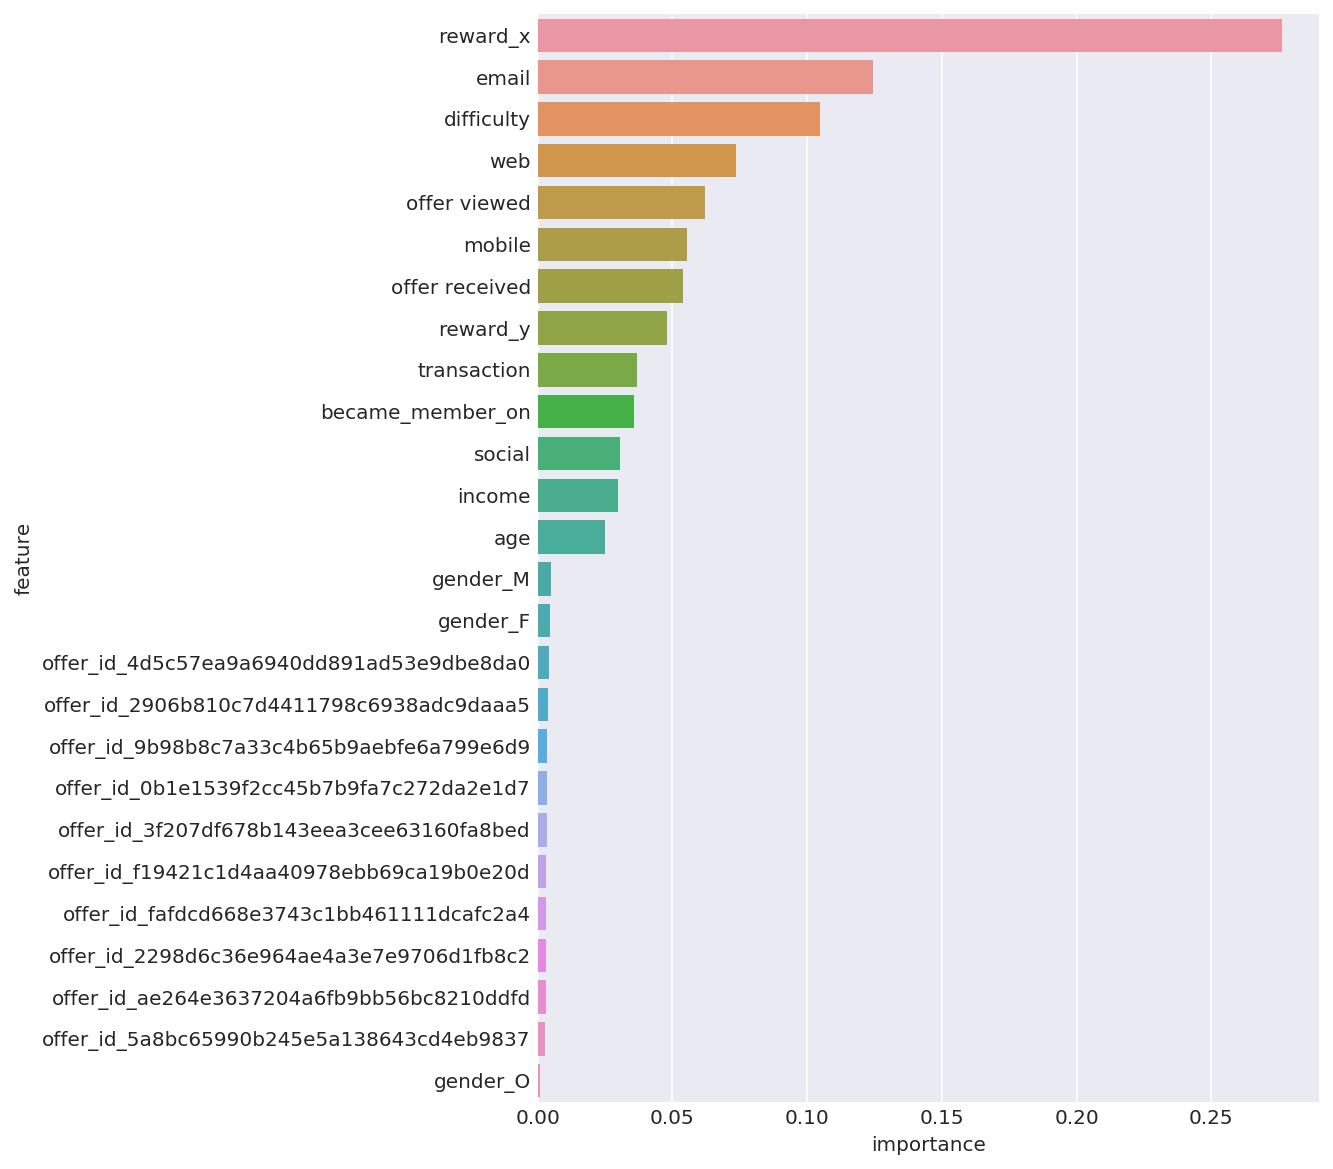

In [128]:
plt.figure(figsize=(7,10))
sns.barplot(y='feature',x='importance',data=feature_imp_view);

**Reward**  is the most important factor, followed by email

In [129]:
from sklearn.tree import DecisionTreeClassifier

In [130]:
clf_dt = DecisionTreeClassifier(random_state = 10)
dt_train_f1, dt_test_f1, dt_model = train_test(clf_dt)

In [131]:
dt = {'Model': [ dt_model], 'train F1 score':[dt_train_f1], 'test F1 score': [dt_test_f1]}
benchmark_dt = pd.DataFrame(dt)

In [132]:
benchmark_dt

,Model,train F1 score,test F1 score
0,DecisionTreeClassifier,1.0,0.926618


In [133]:
from sklearn.ensemble import AdaBoostClassifier

In [134]:
clf_ada = AdaBoostClassifier(n_estimators=200, base_estimator=rfc, random_state=0)


In [135]:
clf_ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=200, random_state=0)

In [136]:
y_preds = clf_ada.predict(X_test)

In [137]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_preds))

Accuracy: 0.946050096339


In [139]:
Accuracy of adaboost classifier 94.60% 

SyntaxError: invalid syntax (<ipython-input-139-6c2a9ed8daae>, line 1)

Ada boost classifier impressive  accuracy is **94.6%** 

## Motivation 

Identifying and classifying features that influence an offer completion. It would be interesting to understand who and why complete a certain offer and what insights does this dataset carry

## CONCLUSION 

Data Understanding

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

Data Cleaning
Portfolio
    1. Cleaned the channels field to include one entry for every row
    2. Cleaned the 
Profile
    1. Cleaned the age for records greater than or equal to 118
    2. Cleaned gender for null and income imputed with mean for null
    3. Chose a subset based on age < 80 as it made sense
    4. Showed age, gender and income based distribution
Transcript
    1. Cleaned the value field to get the offer id and associated amount and reward
    2. dummy variable for event
    
Data Preparation
    1. Combine the resultant profile, transcript and portfolio information
    2. Aggregating to create one record per person
    3. Analyze distibution of offer completed by Gender and Income
    4. Create dummies for gender and offer Id 
    
Modeling 
    1. Creation of training and testing datasets using the final output data
    2. Train a Random forest model Decision tree model followed by an ADA boost classifier 
    3. Fit the model onto the test data 
    4. tree-based models as I wanted to check feature importance
    5. GridSearchCV() to find the best parameters for my model

Evaluation
    1. used F1 score for measurement of accuracy
    2. Decision tree comes back with an accuracy of 92% with the test data
    3. Random Forest comes in with a 94 % 
    4. ADABoost classifier comes back with an accuracy of 94% with the test data 

Result 
    1. This is a pretty good score, we are able to zero in on specific factors that influence the offer completion
    2. Female population looks more likely to complete an offer
    3. Higher percentage of interest to social media based offers
    4. People with a higher median in icome usually tend to complete the offers especially females
    5. Most popular offer type is dicount & BOGO

Next 
1. Improvements - probably add new features and see how they can influence the offers 

